# Bayes Flow Netkork - Test - Binary Mnist.

# Cargando Binary MNIST

In [1]:
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary
import matplotlib.pyplot as plt
%matplotlib inline

import torchvision
import torchvision.transforms as transforms

# Define the data transformation
transform = transforms.Compose([
    transforms.ToTensor(), 
    transforms.Normalize((0.5,), (0.5,)),  
])

# Download and load the MNIST dataset
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, transform=transform, download=True)

# Create data loaders
batch_size = 64
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

100%|██████████| 9912422/9912422 [00:00<00:00, 26271640.16it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 69378976.99it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 18246964.24it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 17972196.95it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [2]:
class DynamicallyBinarizedMNIST(torchvision.datasets.MNIST):
    def __init__(self, root, train=True, transform=None, target_transform=None, download=False):
        super(DynamicallyBinarizedMNIST, self).__init__(root, train=train, transform=transform,
                                                        target_transform=target_transform, download=download)

    def __getitem__(self, index):
        img, target = self.data[index], int(self.targets[index])

        if self.transform is not None:
            img = self.transform(img)

        return img, target

def collate_dynamic_binarize(batch):
    # Collate function that samples a binarization probability for each batch
    images, targets = zip(*batch)
    binarization_probs = torch.rand(len(images))

    binarized_images = []
    for img, prob in zip(images, binarization_probs):
        binarized_img = (img > prob).float()
        binarized_images.append(binarized_img)

    return torch.stack(binarized_images)[:, None, ...].to(torch.int64), torch.tensor(targets)

# Define transformations
transform = transforms.Compose([
    transforms.ToTensor()
])

# Create the dynamically binarized MNIST dataset
train_dataset = DynamicallyBinarizedMNIST(root='./data', train=True, download=True) #transform=transform
test_dataset = DynamicallyBinarizedMNIST(root='./data', train=False, download=True) #transform=transform

# Create data loaders with the collate function
batch_size = 512
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_dynamic_binarize)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_dynamic_binarize)


100%|██████████| 9912422/9912422 [00:00<00:00, 32361665.49it/s]


Extracting ./data/DynamicallyBinarizedMNIST/raw/train-images-idx3-ubyte.gz to ./data/DynamicallyBinarizedMNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 20115525.38it/s]

Extracting ./data/DynamicallyBinarizedMNIST/raw/train-labels-idx1-ubyte.gz to ./data/DynamicallyBinarizedMNIST/raw




100%|██████████| 1648877/1648877 [00:00<00:00, 21675154.03it/s]


Extracting ./data/DynamicallyBinarizedMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/DynamicallyBinarizedMNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 2661803.66it/s]


Extracting ./data/DynamicallyBinarizedMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/DynamicallyBinarizedMNIST/raw



118


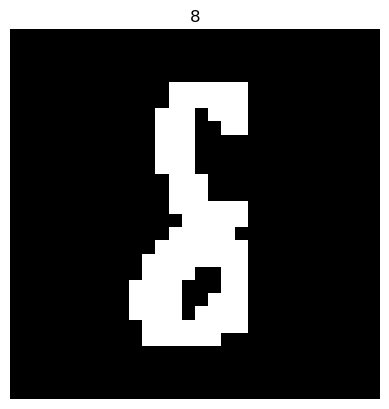

In [3]:
print(len(train_loader))
for i in train_loader:
  x, y = i
  plt.imshow(x[0][0], cmap='Greys_r', interpolation='nearest')
  plt.axis('off')
  plt.title(y[0].numpy())
  break

In [4]:
from bfn_model import BayesianFlowNetwork2D
from networks import UNet

test = UNet(2, 1)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
test.to(device)

UNet(
  (e11): Conv2d(2, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (dpe11): Dropout(p=0.3, inplace=False)
  (e12): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (dpe12): Dropout(p=0.3, inplace=False)
  (e13): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (e21): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (dpe21): Dropout(p=0.3, inplace=False)
  (e22): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (dpe22): Dropout(p=0.3, inplace=False)
  (e23): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (e31): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (dpe31): Dropout(p=0.3, inplace=False)
  (e32): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (dpe32)

In [5]:
from torch.optim import AdamW
from tqdm.auto import tqdm
import torch_ema

bfn = BayesianFlowNetwork2D(UNet(2, 1, dropout=0.5), 28, 2)
ema = torch_ema.ExponentialMovingAverage(bfn.net.parameters(), decay=0.9999)

bfn.cuda()
ema.to(device)

optim = AdamW(bfn.parameters(), lr=2e-4, betas=(0.9, 0.98), weight_decay=0.01)

/home/ccdonosoo/.local/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Epoch 100/100: 100%|██████████| 118/118 [00:28<00:00,  4.20it/s]


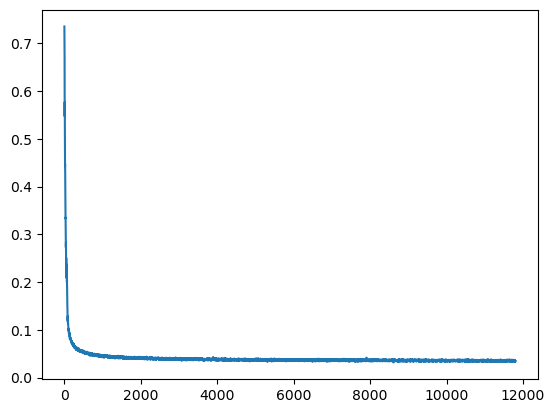

In [6]:
losses = []

epochs = 100
best_loss = 10000
k = 0
early_stopping = False
patience = 1e6

for i in range(epochs):
  for X, _ in tqdm(train_loader, desc=f"Epoch {i+1}/{epochs}"):
      optim.zero_grad()
      loss = bfn.process(X.to(device))
      loss.backward()
      optim.step()
      ema.update()
      losses.append(loss.item())
      if loss.item() < best_loss:
        best_loss = loss.item()
        k = 0
      else:
        k += 1
        if k == patience:
          k = 0
          early_stopping = True
          break
  if early_stopping:
    break

plt.plot(losses)
plt.ylabel("Training_Losses")
plt.xlabel("Steps")


Text(0.5, 0, 'Steps')

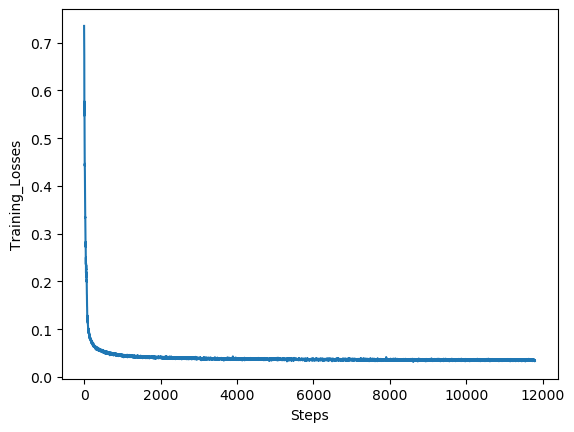

In [13]:
plt.plot(losses)
plt.ylabel("Training_Losses")
plt.xlabel("Steps")

(0, 0.1)

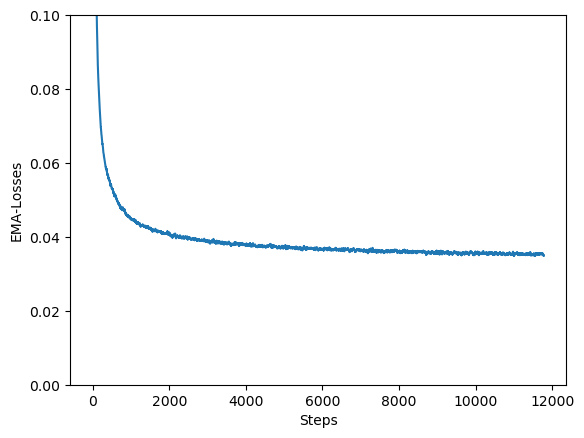

In [12]:
def moving_average(data, window_size):
    moving_avg = []
    for i in range(len(data) - window_size + 1):
        window = data[i : i + window_size]
        avg = sum(window) / window_size
        moving_avg.append(avg)
    return moving_avg

plt.plot(moving_average(losses, 20))
plt.ylabel("EMA-Losses")
plt.xlabel("Steps")
plt.ylim(0, 0.1)

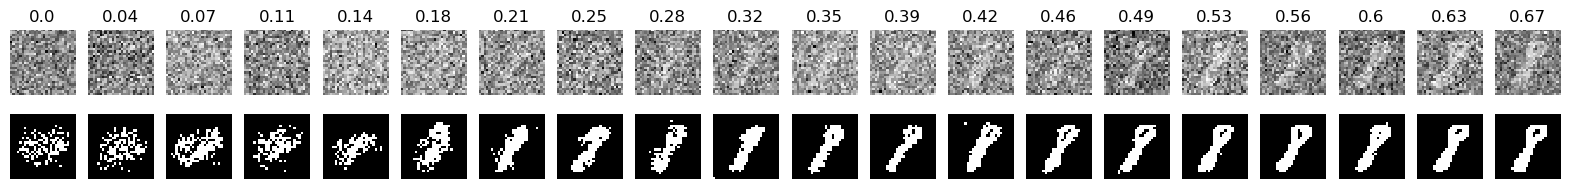

In [10]:
def get_sample():
  for i in train_loader:
    x, y = i
    break
  return x
     
x_0 = get_sample()[0][0]

Ys = []
Ks = []
Ts = []

# We set t going from 0 to 2/3
for t in np.linspace(0.001, 0.667, 20):
  l, y, k, t_ = bfn.process(x_0[None, :, :, None].to(torch.int64).to(device), training=False, t=t)

  Ys.append(y.permute(0, 2, 1, 3).cpu().numpy()[0, :, :, 1])
  Ks.append(k.permute(0, 2, 1).cpu().numpy()[0])
  Ts.append(t)
     

fig, ax = plt.subplots(2, 20, figsize=(20, 2))

for i in range(20):
  ax[0, i].imshow(Ys[i], cmap='Greys_r')
  ax[1, i].imshow(Ks[i], cmap='Greys_r')
  ax[0, i].axis('off')
  ax[1, i].axis('off')

  ax[0, i].set_title(np.round(Ts[i], 2))

plt.savefig("MNIST_GENERATED.pdf", dpi=400)